# Exercises week 42

**Kjersti Stangeland**
**October 13-17, 2025**

Date: **Deadline is Friday October 17 at midnight**


# Overarching aims of the exercises this week

The aim of the exercises this week is to train the neural network you implemented last week.

To train neural networks, we use gradient descent, since there is no analytical expression for the optimal parameters. This means you will need to compute the gradient of the cost function wrt. the network parameters. And then you will need to implement some gradient method.

You will begin by computing gradients for a network with one layer, then two layers, then any number of layers. Keeping track of the shapes and doing things step by step will be very important this week.

We recommend that you do the exercises this week by editing and running this notebook file, as it includes some checks along the way that you have implemented the neural network correctly, and running small parts of the code at a time will be important for understanding the methods. If you have trouble running a notebook, you can run this notebook in google colab instead(https://colab.research.google.com/drive/1FfvbN0XlhV-lATRPyGRTtTBnJr3zNuHL#offline=true&sandboxMode=true), though we recommend that you set up VSCode and your python environment to run code like this locally.

First, some setup code that you will need.


In [122]:
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# Defining some activation functions
def ReLU(z):
    return np.where(z > 0, z, 0)


# Derivative of the ReLU function
def ReLU_der(z):
    return np.where(z > 0, 1, 0)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def mse(predict, target):
    return np.mean((predict - target) ** 2)

# Exercise 1 - Understand the feed forward pass

**a)** Complete last weeks' exercises if you haven't already (recommended).


# Exercise 2 - Gradient with one layer using autograd

For the first few exercises, we will not use batched inputs. Only a single input vector is passed through the layer at a time.

In this exercise you will compute the gradient of a single layer. You only need to change the code in the cells right below an exercise, the rest works out of the box. Feel free to make changes and see how stuff works though!

**a)** If the weights and bias of a layer has shapes (10, 4) and (10), what will the shapes of the gradients of the cost function wrt. these weights and this bias be?


__Answer 2a):__

From the lecture notes:

$\frac{\partial C}{\partial w_{jk}^l} = \delta_j^l \cdot a_k^{l-1}$, with: $\delta_j^l = \frac{\partial C}{\partial a_j^l} \cdot \sigma '$,  which is the gradient for the weigth $w_{jk}^l$, which corresponds to layer $l$ and node $jk$. For the bias, the gradient is $\frac{\partial C}{\partial b_j^l} = \delta_j^l$, where: $\delta_j^l = \frac{\partial C}{\partial a_j^l} \cdot \sigma '$. 

With weights with shape (10,4) and bias (10,), then the input is (4,). So $z = W*x + b$ has shape (10,), and then the activation function $a = \sigma(z)$ has also shape (10,). So the gradient of the bias must also have shape (10,). The gradient of the weight has shape (10, 4). 

Say that j is the number of nodes, k is the number of inputs, then this reasoning makes sense at least in my brain. 

**b)** Complete the feed_forward_one_layer function. It should use the sigmoid activation function. Also define the weigth and bias with the correct shapes.


In [123]:
def feed_forward_one_layer(W, b, x):
    z = W @ x + b
    a = sigmoid(z)
    return a


def cost_one_layer(W, b, x, target):
    predict = feed_forward_one_layer(W, b, x)
    return mse(predict, target)


x = np.random.rand(2)
target = np.random.rand(3)

W = np.random.randn(3, 2)
b = np.random.randn(3)

**c)** Compute the gradient of the cost function wrt. the weigth and bias by running the cell below. You will not need to change anything, just make sure it runs by defining things correctly in the cell above. This code uses the autograd package which uses backprogagation to compute the gradient!


In [124]:
autograd_one_layer = grad(cost_one_layer, [0, 1])
W_g, b_g = autograd_one_layer(W, b, x, target)
print(W_g, b_g)

[[ 0.02138296  0.01262527]
 [-0.02122727 -0.01253334]
 [ 0.00959348  0.00566434]] [ 0.06176618 -0.06131646  0.02771145]


# Exercise 3 - Gradient with one layer writing backpropagation by hand

Before you use the gradient you found using autograd, you will have to find the gradient "manually", to better understand how the backpropagation computation works. To do backpropagation "manually", you will need to write out expressions for many derivatives along the computation.


We want to find the gradient of the cost function wrt. the weight and bias. This is quite hard to do directly, so we instead use the chain rule to combine multiple derivatives which are easier to compute.

$$
\frac{dC}{dW} = \frac{dC}{da}\frac{da}{dz}\frac{dz}{dW}
$$

$$
\frac{dC}{db} = \frac{dC}{da}\frac{da}{dz}\frac{dz}{db}
$$


**a)** Which intermediary results can be reused between the two expressions?


__Answer 3a):__
The gradient of the cost function with respect to the weights:
$$
\frac{dC}{dW} = \frac{dC}{da}\frac{da}{dz}\frac{dz}{dW}
$$

We have:
* $z^l = W^l*a^{l-1} + b^l$
* $a^l = \sigma(z^l)$

So:
* $\frac{\partial z^l}{\partial W^l} = a^{l-1}$
* $\frac{\partial z^l}{\partial a^{l-1}} = W^l$

In the case of Sigmoid being the activation function, we then have:
* $\sigma(z) = \frac{1}{1 + e^{-z}}$
* $\frac{\partial a^l}{\partial z^l} = \sigma ' = \sigma(z^l) \cdot (1 - \sigma(z^l)) = a^l(1 - a^l)$

In the case of MSE being the cost function, we have:
* $C = \frac{1}{2} (a^l - y)^2 = \frac{1}{2} ((a^l)^2 - 2 a^ly + y^2)$
* $\frac{\partial C}{\partial a^l} = (a^l - y)$

Then: $\frac{dC}{dW} = (a^l - y) \cdot a^l(1 - a^l) \cdot a^{l-1}$

And we can define: $\delta^l = \frac{\partial C}{\partial a^l} \cdot \sigma '$, which yields: $\frac{dC}{dW} = \delta^l \cdot a^{l-1}$ 


Now, for the gradient of the bias:

$$
\frac{dC}{db} = \frac{dC}{da}\frac{da}{dz}\frac{dz}{db}
$$

Using what we already found, we have: $\frac{dz}{db} = 1$, which leaves us with: $\frac{dC}{db} = \delta^l$ 

**b)** What is the derivative of the cost wrt. the final activation? You can use the autograd calculation to make sure you get the correct result. Remember that we compute the mean in mse.


In [125]:
z = W @ x + b
a = sigmoid(z)

predict = a

def mse_der(predict, target):
    return 2*(predict - target)/predict.size

print(mse_der(predict, target))

cost_autograd = grad(mse, 0)
print(cost_autograd(predict, target))

[ 0.28648394 -0.27523393  0.13254047]
[ 0.28648394 -0.27523393  0.13254047]


**c)** What is the expression for the derivative of the sigmoid activation function? You can use the autograd calculation to make sure you get the correct result.


In [126]:
def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))


print(sigmoid_der(z))

sigmoid_autograd = elementwise_grad(sigmoid, 0)
print(sigmoid_autograd(z))

[0.21560084 0.22277944 0.20907917]
[0.21560084 0.22277944 0.20907917]


**d)** Using the two derivatives you just computed, compute this intermetidary gradient you will use later:

$$
\frac{dC}{dz} = \frac{dC}{da}\frac{da}{dz}
$$


In [127]:
dC_da = mse_der(predict, target)
dC_dz = dC_da * sigmoid_der(z)

**e)** What is the derivative of the intermediary z wrt. the weight and bias? What should the shapes be? The one for the weights is a little tricky, it can be easier to play around in the next exercise first. You can also try computing it with autograd to get a hint.


__Answer 3e):__
$$
\frac{dC}{dz} = \frac{dC}{da}\frac{da}{dz}
$$

This is the cost function derivated with respect to z, which is the expression which will go through the activation function of the layer and afterwards be sent as output to the next layer.

$$
\frac{dC}{dz} = \frac{dC}{da}\frac{da}{dz}
$$

$$
= \frac{2}{n}(a^l - y) * \sigma(z^l)*(1 - \sigma(z^l))
$$

(I dont really understand the question, isnt this what was in 3a?)

**f)** Now combine the expressions you have worked with so far to compute the gradients! Note that you always need to do a feed forward pass while saving the zs and as before you do backpropagation, as they are used in the derivative expressions


In [128]:
dC_da = (2/predict.size)*(predict - target)
dC_dz = dC_da * sigmoid_der(z)
dC_dW = np.outer(dC_dz, x)
dC_db = dC_dz

print(dC_dW, dC_db)

[[ 0.02138296  0.01262527]
 [-0.02122727 -0.01253334]
 [ 0.00959348  0.00566434]] [ 0.06176618 -0.06131646  0.02771145]


You should get the same results as with autograd.


In [129]:
W_g, b_g = autograd_one_layer(W, b, x, target)
print(W_g, b_g)

[[ 0.02138296  0.01262527]
 [-0.02122727 -0.01253334]
 [ 0.00959348  0.00566434]] [ 0.06176618 -0.06131646  0.02771145]


# Exercise 4 - Gradient with two layers writing backpropagation by hand


Now that you have implemented backpropagation for one layer, you have found most of the expressions you will need for more layers. Let's move up to two layers.


In [130]:
x = np.random.rand(2)
target = np.random.rand(4)

W1 = np.random.rand(3, 2)
b1 = np.random.rand(3)

W2 = np.random.rand(4, 3)
b2 = np.random.rand(4)

layers = [(W1, b1), (W2, b2)]

In [131]:
z1 = W1 @ x + b1
a1 = sigmoid(z1)
z2 = W2 @ a1 + b2
a2 = sigmoid(z2)

We begin by computing the gradients of the last layer, as the gradients must be propagated backwards from the end.

**a)** Compute the gradients of the last layer, just like you did the single layer in the previous exercise.


In [132]:
dC_da2 = (2/a2.size)*(a2 - target)
dC_dz2 = dC_da2 * sigmoid_der(z2)
dC_dW2 = np.outer(dC_dz2, a1)
dC_db2 = dC_dz2

To find the derivative of the cost wrt. the activation of the first layer, we need a new expression, the one furthest to the right in the following.

$$
\frac{dC}{da_1} = \frac{dC}{dz_2}\frac{dz_2}{da_1}
$$

**b)** What is the derivative of the second layer intermetiate wrt. the first layer activation? (First recall how you compute $z_2$)

$$
\frac{dz_2}{da_1}
$$


__Answer 4b):__
$z_2 = W_2*a_1 + b_2$, so:

$$\frac{dz_2}{da_1} = W_2$$

**c)** Use this expression, together with expressions which are equivelent to ones for the last layer to compute all the derivatives of the first layer.

$$
\frac{dC}{dW_1} = \frac{dC}{da_1}\frac{da_1}{dz_1}\frac{dz_1}{dW_1}
$$

$$
\frac{dC}{db_1} = \frac{dC}{da_1}\frac{da_1}{dz_1}\frac{dz_1}{db_1}
$$


In [133]:
dC_da1 = W2.T @ dC_dz2 
dC_dz1 = dC_da1 * sigmoid_der(z1)
dC_dW1 = np.outer(dC_dz1, x)
dC_db1 = dC_dz1

In [134]:
print(dC_dW1, dC_db1)
print(dC_dW2, dC_db2)

[[0.00941925 0.00689284]
 [0.00657652 0.00481258]
 [0.00802484 0.00587243]] [0.01203051 0.0083997  0.01024954]
[[0.03138038 0.03263823 0.03061599]
 [0.02292424 0.02384314 0.02236584]
 [0.02538801 0.02640567 0.02476959]
 [0.00474303 0.00493315 0.00462749]] [0.03985282 0.02911359 0.03224256 0.00602361]


**d)** Make sure you got the same gradient as the following code which uses autograd to do backpropagation.


In [135]:
def feed_forward_two_layers(layers, x):
    W1, b1 = layers[0]
    z1 = W1 @ x + b1
    a1 = sigmoid(z1)

    W2, b2 = layers[1]
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)

    return a2

In [136]:
def cost_two_layers(layers, x, target):
    predict = feed_forward_two_layers(layers, x)
    return mse(predict, target)

grad_two_layers = grad(cost_two_layers, 0)
g = grad_two_layers(layers, x, target)
g

[(array([[0.00941925, 0.00689284],
         [0.00657652, 0.00481258],
         [0.00802484, 0.00587243]]),
  array([0.01203051, 0.0083997 , 0.01024954])),
 (array([[0.03138038, 0.03263823, 0.03061599],
         [0.02292424, 0.02384314, 0.02236584],
         [0.02538801, 0.02640567, 0.02476959],
         [0.00474303, 0.00493315, 0.00462749]]),
  array([0.03985282, 0.02911359, 0.03224256, 0.00602361]))]

In [137]:
print(dC_dW1)
print()
print(dC_db1)

[[0.00941925 0.00689284]
 [0.00657652 0.00481258]
 [0.00802484 0.00587243]]

[0.01203051 0.0083997  0.01024954]


In [138]:
print(dC_dW2)
print()
print(dC_db2)

[[0.03138038 0.03263823 0.03061599]
 [0.02292424 0.02384314 0.02236584]
 [0.02538801 0.02640567 0.02476959]
 [0.00474303 0.00493315 0.00462749]]

[0.03985282 0.02911359 0.03224256 0.00602361]


**e)** How would you use the gradient from this layer to compute the gradient of an even earlier layer? Would the expressions be any different?


__Answer 4e):__
In back propagation, to find the gradients of an earlier layer, the chain rule applies. So the method and qlgorithm is similar, but the length of the expressions increase when using the chain rule. It evolves because the input to one layer is given by the output of an earlier layer, and such all layers connect.

# Exercise 5 - Gradient with any number of layers writing backpropagation by hand


Well done on getting this far! Now it's time to compute the gradient with any number of layers.

First, some code from the general neural network code from last week. Note that we are still sending in one input vector at a time. We will change it to use batched inputs later.


In [139]:
def create_layers(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        b = np.random.randn(layer_output_size)
        layers.append((W, b))

        i_size = layer_output_size
    return layers


def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = W @ a + b
        a = activation_func(z)
    return a


def cost(layers, input, activation_funcs, target):
    predict = feed_forward(input, layers, activation_funcs)
    return mse(predict, target)

You might have already have noticed a very important detail in backpropagation: You need the values from the forward pass to compute all the gradients! The feed forward method above is great for efficiency and for using autograd, as it only cares about computing the final output, but now we need to also save the results along the way.

Here is a function which does that for you.


In [140]:
def feed_forward_saver(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = W @ a + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

**a)** Now, complete the backpropagation function so that it returns the gradient of the cost function wrt. all the weigths and biases. Use the autograd calculation below to make sure you get the correct answer.


In [141]:
def backpropagation(
    input, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = dC_dz @ W

        dC_dz = dC_da * activation_der(z)
        dC_dW = np.outer(dC_dz, layer_input)
        dC_db = dC_dz

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

In [142]:
network_input_size = 2
layer_output_sizes = [3, 4]
activation_funcs = [sigmoid, ReLU]
activation_ders = [sigmoid_der, ReLU_der]

layers = create_layers(network_input_size, layer_output_sizes)

x = np.random.rand(network_input_size)
target = np.random.rand(4)

In [143]:
layer_grads = backpropagation(x, layers, activation_funcs, target, activation_ders)
print('dC/dW for layer 1:')
print(layer_grads[0][0])
print('dC/db for layer 1:')
print(layer_grads[0][1])
print('dC/dW for layer 2:')
print(layer_grads[1][0])
print('dC/db for layer 2:')
print(layer_grads[1][1])

dC/dW for layer 1:
[[ 0.0001293   0.00200097]
 [-0.00271749 -0.04205568]
 [ 0.00339058  0.05247238]]
dC/db for layer 1:
[ 0.00268642 -0.05646207  0.07044707]
dC/dW for layer 2:
[[-0.         -0.         -0.        ]
 [-0.         -0.         -0.        ]
 [ 0.02357543  0.04972076  0.07664738]
 [ 0.08242759  0.17384038  0.26798484]]
dC/db for layer 2:
[-0.         -0.          0.14253015  0.49833302]


In [144]:
cost_grad = grad(cost, 0)
g = cost_grad(layers, x, [sigmoid, ReLU], target)

print('dC/dW for layer 1:')
print(g[0][0])
print('dC/db for layer 1:')
print(g[0][1])
print('dC/dW for layer 2:')
print(g[1][0])
print('dC/db for layer 2:')
print(g[1][1])

dC/dW for layer 1:
[[ 0.0001293   0.00200097]
 [-0.00271749 -0.04205568]
 [ 0.00339058  0.05247238]]
dC/db for layer 1:
[ 0.00268642 -0.05646207  0.07044707]
dC/dW for layer 2:
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.02357543 0.04972076 0.07664738]
 [0.08242759 0.17384038 0.26798484]]
dC/db for layer 2:
[0.         0.         0.14253015 0.49833302]


# Exercise 6 - Batched inputs

Make new versions of all the functions in exercise 5 which now take batched inputs instead. See last weeks exercise 5 for details on how to batch inputs to neural networks. You will also need to update the backpropogation function.


In [ ]:
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []
    i_size = network_input_size

    for layer_output_size in layer_output_sizes:
        W = np.random.randn(i_size, layer_output_size)
        b = np.random.randn(layer_output_size, 1)
        layers.append((W, b))

        i_size = layer_output_size
    return layers


def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = W.T @ a + b
        a = activation_func(z)
    return a

def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = W.T @ a + b
        zs.append(z)
        a = activation_func(z)
    return layer_inputs, zs, a


def cost_batch(layers, inputs, activation_funcs, target):
    predictions = feed_forward_batch(inputs, layers, activation_funcs)
    mse_per_sample = np.mean((predictions - target) ** 2, axis=0)
    return mse_per_sample


def backpropagation_batch(
    inputs, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predictions = feed_forward_saver_batch(inputs, layers, activation_funcs)
    batch_size = inputs.shape[1]

    layer_grads = [() for l in layers]

    # Loop over layers backward
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # Last layer: derivative of cost w.r.t activation
            dC_da = cost_der(predictions, target)  # shape: (output_size, batch_size)
        else:
            W_next, b_next = layers[i + 1]
            dC_da = W_next @ dC_dz  

        dC_dz = dC_da * activation_der(z)
        dC_dW = (layer_input @ dC_dz.T) / batch_size
        dC_db = np.mean(dC_dz, axis=1, keepdims=True)

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

In [146]:
batch_size = 10

network_input_size = 2
layer_output_sizes = [3, 4]
activation_funcs = [sigmoid, ReLU]
activation_ders = [sigmoid_der, ReLU_der]

layers = create_layers_batch(network_input_size, layer_output_sizes)

x = np.random.rand(network_input_size, batch_size)
target = np.random.rand(4, batch_size)

In [147]:
layer_grads = backpropagation_batch(x, layers, activation_funcs, target, activation_ders)
print('dC/dW for layer 1:')
print(layer_grads[0][0])
print('dC/db for layer 1:')
print(layer_grads[0][1])
print('dC/dW for layer 2:')
print(layer_grads[1][0])
print('dC/db for layer 2:')
print(layer_grads[1][1])

dC/dW for layer 1:
[[0.01171041 0.01632465 0.00163746]
 [0.00908787 0.01474151 0.00148492]]
dC/db for layer 1:
[[0.01818251]
 [0.02461787]
 [0.00271486]]
dC/dW for layer 2:
[[0.         0.         0.         0.06821137]
 [0.         0.         0.         0.04162008]
 [0.         0.         0.         0.01149188]]
dC/db for layer 2:
[[0.        ]
 [0.        ]
 [0.        ]
 [0.08737146]]


# Exercise 7 - Training


**a)** Complete exercise 6 and 7 from last week, but use your own backpropogation implementation to compute the gradient.
- IMPORTANT: Do not implement the derivative terms for softmax and cross-entropy separately, it will be very hard!
- Instead, use the fact that the derivatives multiplied together simplify to **prediction - target** (see [source1](https://medium.com/data-science/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1), [source2](https://shivammehta25.github.io/posts/deriving-categorical-cross-entropy-and-softmax/))

**b)** Use stochastic gradient descent with momentum when you train your network.


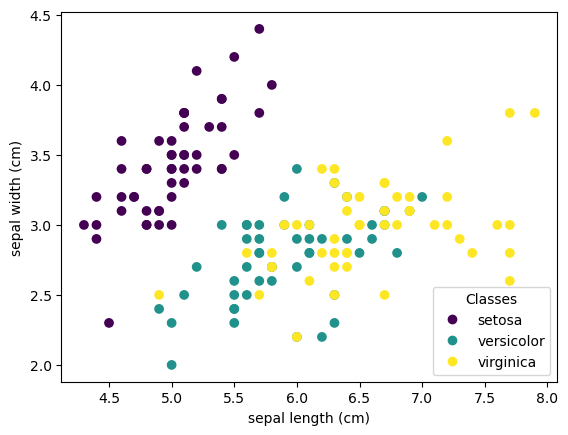

In [148]:
iris = datasets.load_iris()

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [174]:
inputs = iris.data.T  # (4, 150)
targets = np.zeros((3, len(iris.data)))  # (3, 150)
for i, t in enumerate(iris.target):
    targets[t, i] = 1

In [ ]:
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return e_z / np.sum(e_z, axis=0, keepdims=True)

def cross_entropy(predict, target):
    return -np.mean(np.sum(target * np.log(predict + 1e-8), axis=0))

def cross_entropy_der(predictions, targets):
    return predictions - targets

def accuracy(predictions, targets):
    pred_labels = np.argmax(predictions, axis=0)
    true_labels = np.argmax(targets, axis=0)
    return np.mean(pred_labels == true_labels)

def train_network_momentum(
    inputs, layers, activation_funcs, activation_ders,
    targets, learning_rate=0.1, momentum=0.9, epochs=100, batch_size=10
):
    n_samples = inputs.shape[1]
    velocities = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]

    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        inputs_shuffled = inputs[:, indices]
        targets_shuffled = targets[:, indices]

        for start in range(0, n_samples, batch_size):
            end = start + batch_size
            x_batch = inputs_shuffled[:, start:end]
            y_batch = targets_shuffled[:, start:end]

            grads = backpropagation_batch(
                x_batch, layers, activation_funcs, y_batch,
                activation_ders, cost_der=cross_entropy_der
            )

            for i, ((W, b), (dW, db)) in enumerate(zip(layers, grads)):
                vW, vb = velocities[i]
                vW = momentum * vW - learning_rate * dW
                vb = momentum * vb - learning_rate * db
                W += vW
                b += vb
                velocities[i] = (vW, vb)

    return layers


network_input_size = 4
layer_output_sizes = [8, 3]
activation_funcs = [sigmoid, softmax]
activation_ders = [sigmoid_der, lambda z: 1]

layers = create_layers_batch(network_input_size, layer_output_sizes)

trained_layers = train_network_momentum(
    inputs, layers, activation_funcs, activation_ders, targets,
    learning_rate=0.01, momentum=0.9, epochs=100, batch_size=10
)

preds = feed_forward_batch(inputs, trained_layers, activation_funcs)
print("Final accuracy:", accuracy(preds, targets))

Final accuracy: 0.9666666666666667


# Exercise 8 (Optional) - Object orientation

Passing in the layers, activations functions, activation derivatives and cost derivatives into the functions each time leads to code which is easy to understand in isoloation, but messier when used in a larger context with data splitting, data scaling, gradient methods and so forth. Creating an object which stores these values can lead to code which is much easier to use.

**a)** Write a neural network class. You are free to implement it how you see fit, though we strongly recommend to not save any input or output values as class attributes, nor let the neural network class handle gradient methods internally. Gradient methods should be handled outside, by performing general operations on the layer_grads list using functions or classes separate to the neural network.

We provide here a skeleton structure which should get you started.


In [ ]:
class NeuralNetwork:
    def __init__(
        self,
        network_input_size,
        layer_output_sizes,
        activation_funcs,
        activation_ders,
        cost_fun,
        cost_der,
    ):
        pass

    def predict(self, inputs):
        # Simple feed forward pass
        pass

    def cost(self, inputs, targets):
        pass

    def _feed_forward_saver(self, inputs):
        pass

    def compute_gradient(self, inputs, targets):
        pass

    def update_weights(self, layer_grads):
        pass

    # These last two methods are not needed in the project, but they can be nice to have! The first one has a layers parameter so that you can use autograd on it
    def autograd_compliant_predict(self, layers, inputs):
        pass

    def autograd_gradient(self, inputs, targets):
        pass